<a href="https://colab.research.google.com/github/katyk20/Math502w19/blob/master/Notebooks/TimeForecasting_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
! git clone https://github.com/katyk20/distance-education-highered

Cloning into 'distance-education-highered'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 106 (delta 51), reused 22 (delta 7), pack-reused 0
Receiving objects: 100% (106/106), 1.45 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
%cd /content/distance-education-highered
!git pull

In [4]:
# !pip install pmdarima

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Datasets for modeling
Univariate dataset of distance education enrollment by institution

In [6]:
#read in distance enrollment dataset = dist_enrollment_1822 (all years)
enrolled = pd.read_csv('/content/drive/MyDrive/Capstone_Winter2024/PROJECT DATASETS/dist_enrollment18_22.csv')

In [7]:
enrolled.head()

,UNITID,INSTNM,YEAR,IALIAS,STABBR,OBEREG,ICLEVEL,CONTROL,DEGGRANT,LONGITUD,...,EFDELEV,EFDETOT,EFDEEXC,EFDESOM,EFDENON,EFDEEX1,EFDEEX2,EFDEEX3,EFDEEX4,EFDEEX5
0,100654,Alabama A & M University,2018,AAMU,AL,5,1,1,1,-86.568502,...,1,6106,120,1089,4897,87.0,16.0,17.0,0.0,0.0
1,100654,Alabama A & M University,2018,AAMU,AL,5,1,1,1,-86.568502,...,2,5143,76,899,4168,56.0,14.0,6.0,0.0,0.0
2,100654,Alabama A & M University,2018,AAMU,AL,5,1,1,1,-86.568502,...,3,4990,75,894,4021,55.0,14.0,6.0,0.0,0.0
3,100654,Alabama A & M University,2018,AAMU,AL,5,1,1,1,-86.568502,...,11,153,1,5,147,1.0,0.0,0.0,0.0,0.0
4,100654,Alabama A & M University,2018,AAMU,AL,5,1,1,1,-86.568502,...,12,963,44,190,729,31.0,2.0,11.0,0.0,0.0


In [8]:
#filter for  EFDELEV = 1 (Summary line for each institution)

enrolled_sum = enrolled[ enrolled['EFDELEV'] == 1]
# len(enrolled_sum)#30690

In [9]:
#filter for institutions with distance education (e.g. EFDENON (total no distance education) != EFDETOT (total all students))
enrolled_sum2 = enrolled_sum[enrolled_sum['EFDENON'] != enrolled_sum['EFDETOT']]

# len(enrolled_sum2) #17413

In [10]:
#keep columns of interest for time forecasting
#UNITID/YER/STABBR for merging, Target = EFDEEXC
cols_to_keep=['UNITID', 'INSTNM','YEAR', 'EFDETOT','EFDEEXC','EFDESOM', 'EFDENON']
enrolled_sum3 = enrolled_sum2[cols_to_keep]

In [11]:
#remove rows where EFDEEXC == 0
enrolled_sum4=enrolled_sum3[enrolled_sum3['EFDEEXC'] !=0]
# len(enrolled_sum4) #15165

In [12]:
# len(enrolled_sum4['UNITID'].unique().tolist())  #3571 institutions

In [13]:
#find institutions that have EFDEEXC data for all 5 years
#Group the data by 'UNITID' and count the number of unique years for each group
unitid_year_counts = enrolled_sum4.groupby('UNITID')['YEAR'].nunique()

# # Filter 'UNITID's that have EFDEEXC data for each year
filtered_unitids = unitid_year_counts[unitid_year_counts == 5].index
# len(filtered_unitids) #2603 institutions

# # Get institutions corresponding to the filtered 'UNITID's
filtered_de = enrolled_sum4[enrolled_sum4['UNITID'].isin(filtered_unitids)]

# # # Display the institutions that have EFDEEXC data for each year
# print("Institutions with EFDEEXC data appearing for each year:")
# print(filtered_de)
filtered_de[filtered_de['INSTNM']=='Alabama A & M University']

,UNITID,INSTNM,YEAR,EFDETOT,EFDEEXC,EFDESOM,EFDENON
0,100654,Alabama A & M University,2018,6106,120,1089,4897
21567,100654,Alabama A & M University,2019,6172,102,1213,4857
44429,100654,Alabama A & M University,2020,5977,1869,3890,218
67092,100654,Alabama A & M University,2021,5969,426,2513,3030
89561,100654,Alabama A & M University,2022,6007,429,3269,2309


In [14]:
institution_df = filtered_de[['INSTNM','UNITID']]
institution_df = institution_df.drop_duplicates(subset = ['INSTNM'])
institution_df= pd.DataFrame(institution_df)
institution_df = institution_df.rename(columns = {0: 'INSTNM'})
# institution_df

In [15]:
# filtered_de.describe()

In [16]:
#data checks
# missing_values = filtered_de.isnull().sum()
# print("Missing Values:\n", missing_values)

# duplicates = filtered_de.duplicated().sum()
# print("Duplicate Rows:", duplicates)

# data_types = filtered_de.dtypes
# print("Data Types:\n", data_types)

<Axes: >

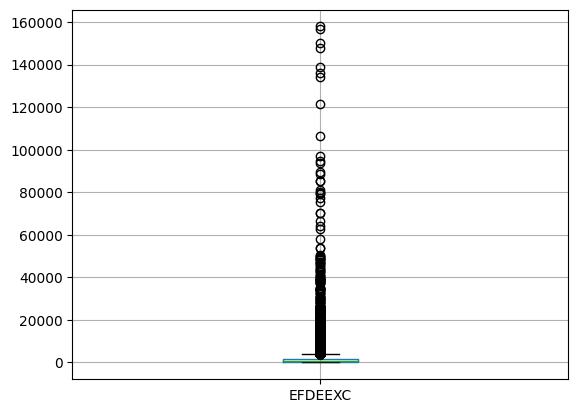

In [17]:
#check for outliers
filtered_de.boxplot(column=['EFDEEXC'])

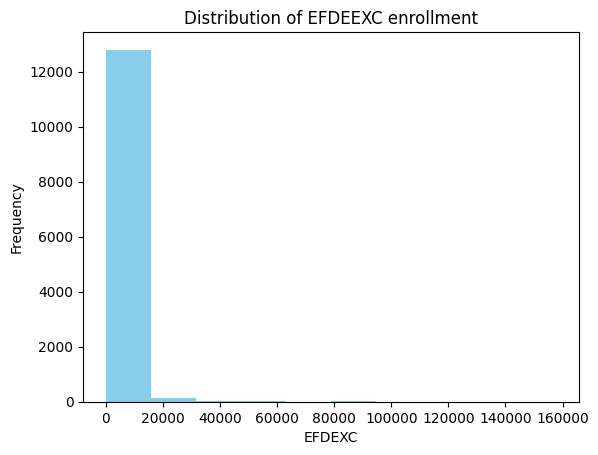

In [18]:
#enrollment distribution - EFDEEXC
data = filtered_de['EFDEEXC']

#handle outliers
transformed_data = np.log(data)

# Create histogram
plt.hist(data,  color='skyblue')

# Labeling axes
plt.xlabel('EFDEXC')
plt.ylabel('Frequency')
plt.title('Distribution of EFDEEXC enrollment')

# Show plot
plt.show()

In [19]:

de_exc = filtered_de[['UNITID', 'YEAR', 'EFDEEXC']]
de_exc


,UNITID,YEAR,EFDEEXC
0,100654,2018,120
5,100663,2018,5603
10,100690,2018,755
14,100706,2018,638
19,100724,2018,437
...,...,...,...
110998,492476,2022,171
111014,492689,2022,28
111027,492759,2022,20
111031,492801,2022,451


#ARIMA

In [20]:
#https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [21]:
check_stationarity (de_exc['EFDEEXC'])


The series is stationary


In [25]:
de_exc['YEAR'] = pd.to_datetime(de_exc['YEAR'].astype(str) + '-10-31')

aggregate_data = de_exc.groupby('YEAR')['EFDEEXC'].sum()
aggregate_data

<ipython-input-25-b35c8443253d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_exc['YEAR'] = pd.to_datetime(de_exc['YEAR'].astype(str) + '-10-31')


YEAR
2018-10-31    3159019
2019-10-31    3382992
2020-10-31    8593245
2021-10-31    5623201
2022-10-31    4898232
Name: EFDEEXC, dtype: int64

In [27]:
# # Split data into train and test sets
train_data = aggregate_data.index.year < 2022  # Use years up to 2021 for training
test_data = aggregate_data.index.year >= 2022

# Fit ARIMA model with the selected parameters on the training data
model_fit = model.fit(train_data)

# Forecast enrollment for the test data period
forecast = model_fit.predict(n_periods=len(test_data))

# Calculate evaluation metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.5199999995222411
Root Mean Squared Error (RMSE): 0.7211102547615317


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1055507177.881, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=171.380, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=167.867, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=171.844, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=165.110, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=163.079, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1053110065.733, Time=0.43 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.930 seconds


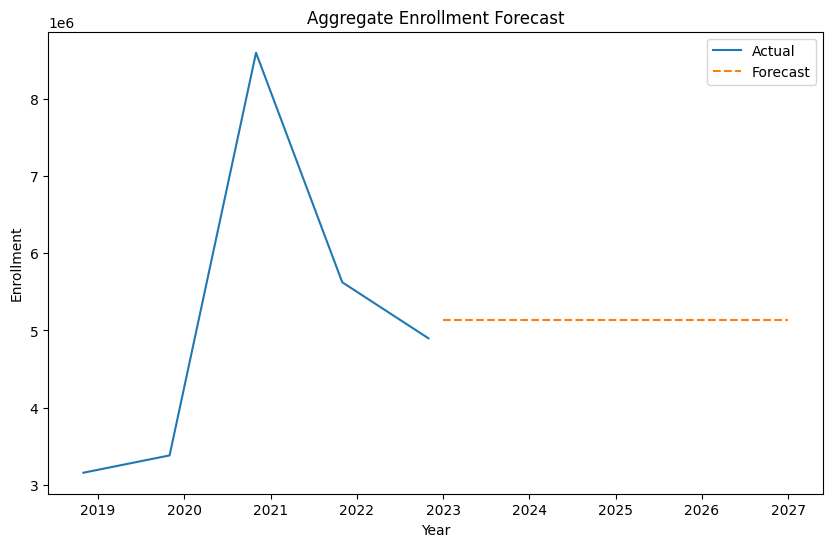

In [26]:
# forecast enrollment for the next 'n_steps' years
n_steps = 5

# Fit ARIMA model
model = auto_arima(aggregate_data, seasonal=False, trace=True)

# Fit ARIMA model with the selected parameters
model_fit = model.fit(aggregate_data)

# Forecast enrollment for the next 'n_steps' years
n_steps = 5
forecast = model_fit.predict(n_periods=n_steps)

# Extend the index to include forecasted years starting from October 31, 2023
forecast_index = pd.date_range(start='2022-10-31', periods=n_steps, freq='Y')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(aggregate_data.index, aggregate_data, label='Actual')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='dashed')
plt.title('Aggregate Enrollment Forecast')
plt.xlabel('Year')
plt.ylabel('Enrollment')
plt.legend()
plt.show()

#ARIMA BY INSTITUTION

In [28]:
def find_institution_id(institution_name, institution_df):
    """
    Find the institution ID based on the institution name.

    Parameters:
        institution_name (str): Name of the institution to search for.
        institution_df (DataFrame): DataFrame containing institution IDs and names.

    Returns:
        institution_id (str): ID of the institution found (or None if not found).
    """
    institution_df = institution_df.copy()
    institution_id = institution_df[institution_df['INSTNM'] == institution_name]['UNITID'].values
    if len(institution_id) > 0:
        return institution_id[0]
    else:
        print(f"Institution '{institution_name}' not found.")
        return None

In [135]:
def predict_enrollment_2022(institution_name, enrollment_data, institution_df):
    """
    Predict enrollment for the year 2022 for a specific institution.

    Parameters:
        institution_name (str): Name of the institution to predict enrollment for.
        enrollment_data (DataFrame): DataFrame containing enrollment data.
        institution_df (DataFrame): DataFrame containing institution IDs and names.

    Returns:
        metrics (dict): Dictionary containing evaluation metrics for the prediction.
    """
    # Find the institution ID based on the institution name
    institution_id = find_institution_id(institution_name, institution_df)

    if institution_id is not None:
        # Get data for the specified institution
        institution_data = enrollment_data[enrollment_data['UNITID'] == institution_id].copy()

        # Convert 'year' column to datetime format using .loc
        institution_data.loc[:, 'YEAR'] = pd.to_datetime(institution_data['YEAR'].astype(str))


        # Split data into train and test sets (using data up to 2022 for training)
        train_years = institution_data['YEAR'].dt.year < 2022
        test_years = institution_data['YEAR'].dt.year == 2022
        train_data = institution_data[train_years]['EFDEEXC']
        test_data = institution_data[test_years]['EFDEEXC']

        # Use auto_arima to auto select the optimal ARIMA model parameters
        model = auto_arima(train_data, seasonal=False, trace=True)

        # Fit ARIMA model with the selected parameters on the training data
        model_fit = model.fit(train_data)

        # Forecast enrollment for 2022
        forecast_2022 = model_fit.predict(n_periods=len(test_data))

        plt.bar(['Actual', 'Predicted'], [test_data.values[0], forecast_2022.values[0]])
        plt.xlabel('Data Type')
        plt.ylabel('Enrollment')
        plt.title(f'Actual vs Predicted Enrollment for {institution_name} in 2022')
        plt.grid(False)
        plt.show()

        print (test_data.values)
        print (forecast_2022.values)



        # Calculate evaluation metrics
        mae = np.mean(np.abs(test_data.values - forecast_2022))
        mse = np.mean((test_data.values - forecast_2022) ** 2)
        rmse = np.sqrt(mse)

        # Create a dictionary to store evaluation metrics
        metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }

        return metrics

    else:
        print(f"No data found for institution '{institution_name}'.")
        return None

Enter the name of the institution: Alabama A & M University
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68.301, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=70.047, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=70.071, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=68.066, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=69.696, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.826 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


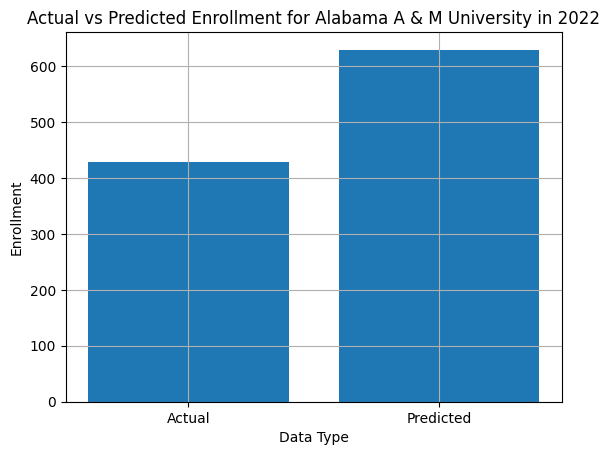

[429]
[629.25]


{'MAE': 200.25, 'MSE': 40100.0625, 'RMSE': 200.25}

In [134]:
#User inputs the institution name
institution_name = input("Enter the name of the institution: ")
enrollment_data = de_exc
predict_enrollment_2022 (institution_name, enrollment_data, institution_df)

In [32]:

def forecast_enrollment_beyond_2022(institution_name, enrollment_data, institution_df, forecast_periods):
    """
    Forecast enrollment beyond 2022 for a specific institution.

    Parameters:
        institution_name (str): Name of the institution to forecast enrollment for.
        enrollment_data (DataFrame): DataFrame containing enrollment data.
        institution_df (DataFrame): DataFrame containing institution IDs and names.
        forecast_periods (int): Number of periods to forecast enrollment for beyond 2022.

    Returns:
        None
    """
    # Find the institution ID based on the institution name
    institution_id = find_institution_id(institution_name, institution_df)

    if institution_id is not None:
        # Get data for the specified institution
        institution_data = enrollment_data[enrollment_data['UNITID'] == institution_id].copy()

        # Convert 'year' column to datetime format using .loc
        institution_data.loc[:, 'YEAR'] = pd.to_datetime(institution_data['YEAR'].astype(str))

        # Split data into train and test sets (using data up to 2022 for training)
        train_years = institution_data['YEAR'].dt.year <= 2022
        train_data = institution_data[train_years]

        # Use auto_arima to auto select the optimal ARIMA model parameters
        model = auto_arima(train_data['EFDEEXC'], seasonal=False, trace=True)

        # Fit ARIMA model with the selected parameters on the training data
        model_fit = model.fit(train_data['EFDEEXC'])

        # Forecast enrollment for the specified number of periods beyond 2022
        forecast_values = model_fit.predict(n_periods=forecast_periods)

        # Create a date range for the forecasted periods
        forecast_dates = pd.date_range(start='2023-01-01', periods=forecast_periods, freq='Y')

        # Plot actual data (2018-2022) and forecasted data (2023-2026)
        plt.plot(train_data['YEAR'], train_data['EFDEEXC'], label='Actual Data')
        plt.plot(forecast_dates, forecast_values, label='Forecasted Data')
        plt.xlabel('Year')
        plt.ylabel('Enrollment')
        plt.title(f'Enrollment Forecast for {institution_name}')
        plt.legend()
        plt.show()

    else:
        print(f"No data found for institution '{institution_name}'.")


Enter the name of the institution: Alabama A & M University
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=161.742, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84.003, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=85.579, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=85.709, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=83.042, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=84.757, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.441 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


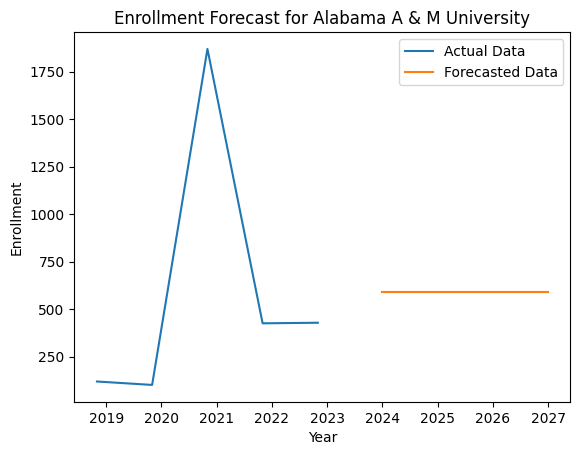

In [33]:
# Ask the user to input the institution name
institution_name = input("Enter the name of the institution: ")
enrollment_data = de_exc
forecast_periods = 4
forecast_enrollment_beyond_2022(institution_name, enrollment_data, institution_df, forecast_periods)

#ARIMA - Adding exogenous variables

In [95]:
de_exc_exog = filtered_de[['YEAR', 'EFDEEXC', 'EFDESOM', 'EFDENON']]

de_exc_exog.loc[:, 'YEAR'] = pd.to_datetime(de_exc_exog['YEAR'].astype(str) + '-10-31')

# # Aggregate the data by year
aggregate_data2 = de_exc_exog.groupby('YEAR')[['EFDEEXC', 'EFDESOM', 'EFDENON']].sum()

# # Reset the index to make 'YEAR' a regular column
aggregate_data2 = aggregate_data2.reset_index()

# # Convert 'YEAR' column back to datetime format
# aggregate_data2['YEAR'] = pd.to_datetime(aggregate_data2['YEAR'], format='%Y')

# # # Set 'YEAR' column as the index with annual frequency
aggregate_data2.set_index('YEAR', inplace=True)
aggregate_data2.index.freq = 'A-OCT'

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=137.704, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=136.191, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=134.172, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132.142, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=133.952, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.281 seconds


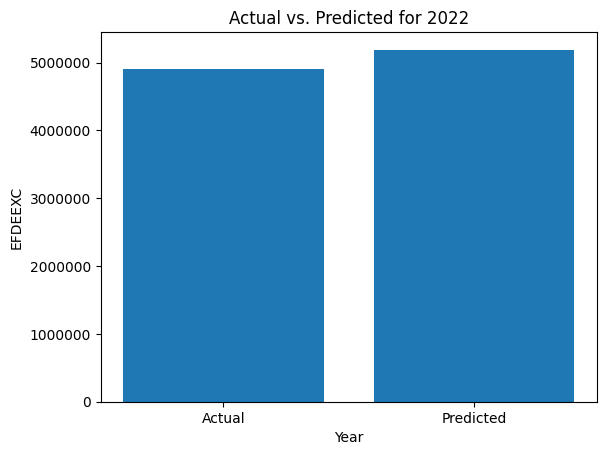

MAE: 291382.25
MSE: 84903615615.0625
RMSE: 291382.25


In [111]:


# Split the data into training and testing sets
train = aggregate_data2[aggregate_data2.index.year < 2022]
test = aggregate_data2[aggregate_data2.index.year == 2022]

# Use auto_arima to auto select the optimal ARIMA model parameters
model = auto_arima(train['EFDEEXC'], exogenous=train[['EFDESOM', 'EFDENON']], seasonal=False, trace=True)

# Fit ARIMA model with the selected parameters on the training data
model_fit = model.fit(train['EFDEEXC'], exogenous=train[['EFDESOM', 'EFDENON']])


# # Fit ARIMAX model
# model = ARIMA(train['EFDEEXC'], order=(0,0,0), exog=train[['EFDESOM', 'EFDENON']])
# model_fit = model.fit()

# Make predictions
prediction = model_fit.predict(steps=len(test), exog=test[['EFDESOM', 'EFDENON']])[0]
# print(prediction)


# Create a bar plot
plt.bar(['Actual', 'Predicted'], [test['EFDEEXC'].values[0], prediction])
plt.xlabel('Year')
plt.ylabel('EFDEEXC')
plt.title('Actual vs. Predicted for 2022')
# Remove scientific notation from y-axis
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Actual value for 2022
actual = test['EFDEEXC'].values[0]

# Calculate MAE
mae = mean_absolute_error([actual], [prediction])

# Calculate MSE
mse = mean_squared_error([actual], [prediction])

# Calculate RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)